In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
from tqdm import tqdm
from math import sqrt

In [2]:
file = open('model_2d_A.pkl', 'rb')

info = pickle.load(file)
coordinates = pickle.load(file)
radii = pickle.load(file)
file.close()

n_atoms = coordinates.shape[0]

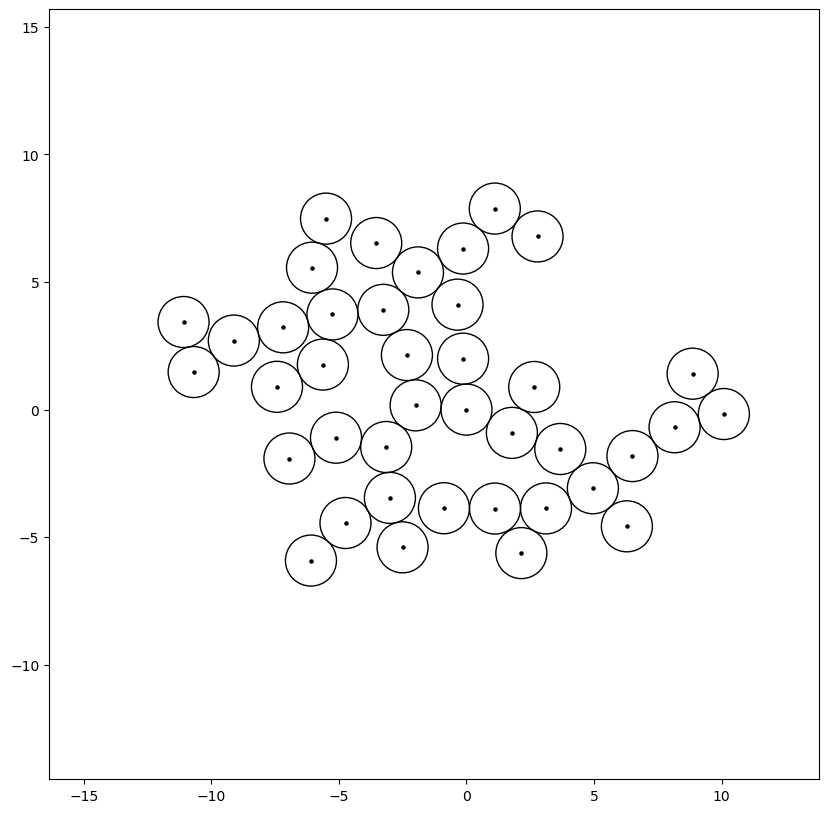

In [3]:
plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_atoms):
    ax.add_patch(plt.Circle(coordinates[ii,:], radius= 1.0, color='k', fill=False))

plt.scatter(coordinates[:,0], coordinates[:,1], s=5, c='k')

l_box = np.abs(coordinates).max() + 4.0
center = coordinates.mean(0)
plt.axis('scaled')
plt.xlim(-l_box+center[0],l_box+center[0])
plt.ylim(-l_box+center[1],l_box+center[1])
plt.show()

In [4]:
from scipy.spatial import Voronoi

In [5]:
voronoi = Voronoi(coordinates)

In [6]:
centers = voronoi.vertices
n_alphaspheres = centers.shape[0]

In [7]:
atoms_of_alphasphere = {ii:[] for ii in range(n_alphaspheres)}
atoms_of_alphasphere[-1] = []
alphaspheres_of_atom = {ii:[] for ii in range(n_atoms)}

In [8]:
for atom_index, region_index in enumerate(voronoi.point_region):
    for alphasphere_index in voronoi.regions[region_index]:
        atoms_of_alphasphere[alphasphere_index].append(atom_index)
        alphaspheres_of_atom[atom_index].append(alphasphere_index)

In [9]:
def is_permeable_2(rp, discs, rs):

    disc1 = discs[0,:]
    disc2 = discs[1,:]

    r1 = rs[0]
    r2 = rs[1]

    v12 = disc2-disc1
    d12 = sqrt(v12[0]**2+v12[1]**2)

    if d12>=r1+r2+2*rp:

        return True

    return False


In [10]:
import networkx as nx

rp = 0.5

G = nx.Graph()

for ii in tqdm(range(-1,n_alphaspheres)):

    G.add_node(ii, atoms=atoms_of_alphasphere[ii])

for ii in tqdm(range(-1,n_alphaspheres)):
    
    neighbors=[]
    for jj in atoms_of_alphasphere[ii]:
        for kk in alphaspheres_of_atom[jj]:
            if kk>ii:
                neighbors.append(kk)
    neighbors=np.unique(neighbors)
    
    for jj in neighbors:
        common = np.intersect1d(atoms_of_alphasphere[ii], atoms_of_alphasphere[jj], assume_unique=True)
        if len(common)==2:
            discs = coordinates[common]
            rs = radii[common]
            if is_permeable_2(rp, discs, rs):
                G.add_edge(ii,jj,face=common)            
        elif len(common)>2:
            print('ups')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 7502.84it/s]


In [11]:
G.number_of_nodes()

69

In [12]:
G.number_of_edges()

41

In [13]:
components_networks = [G.subgraph(c).copy() for c in nx.connected_components(G) if len(c)>1]

In [14]:
not_sa_networks=[]
sa_networks=[]
sa_network=None

for component_network in components_networks:
    if len(component_network)>1:
        if -1 in component_network:
            sa_network = component_network
            length, path = nx.single_source_dijkstra(sa_network, -1)
            for ii, depth in length.items():
                sa_network.nodes[ii]['depth']=depth
                sa_network.nodes[ii]['path']=path
            aux_network = sa_network.subgraph([ii for ii in sa_network if ii!=-1]).copy()
            sa_networks = [aux_network.subgraph(c).copy() for c in nx.connected_components(aux_network)]
        else:
            not_sa_networks.append(component_network)

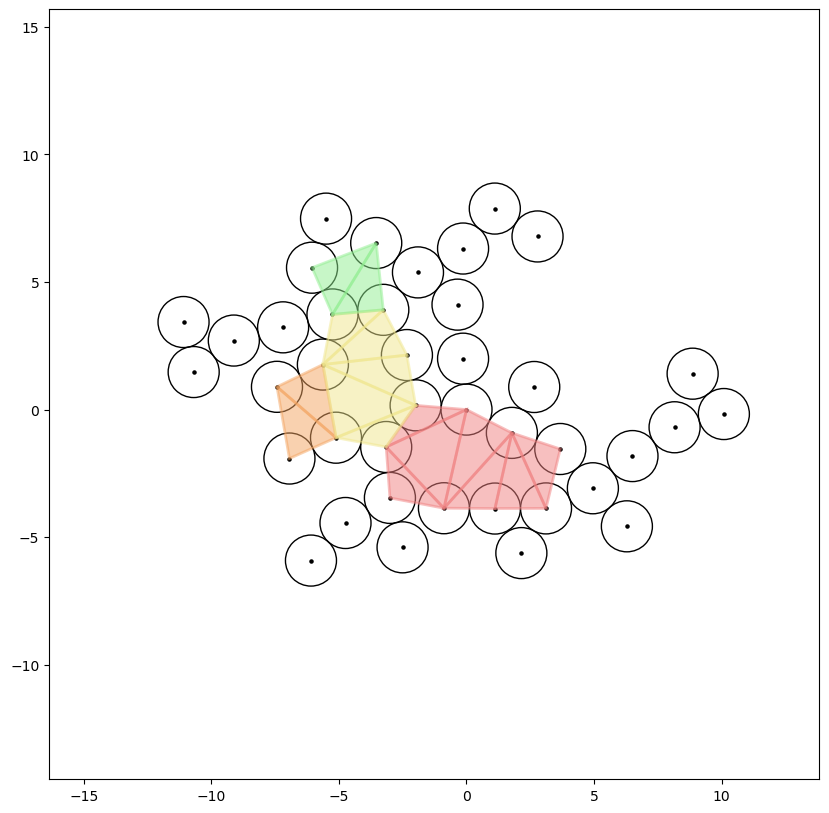

In [32]:
colors = ['lightcoral', 'sandybrown', 'khaki', 'lightgreen', 'mediumaquamarine', 'lightslategrey',
         'lightsteelblue', 'thistle', 'tomato', 'olive']

plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_atoms):
    ax.add_patch(plt.Circle(coordinates[ii,:], radius= 1.0, color='k', fill=False))

plt.scatter(coordinates[:,0], coordinates[:,1], s=5, c='k')

for ii in range(len(not_sa_networks)):
    for asphere_index in not_sa_networks[ii]:
        aux = atoms_of_alphasphere[asphere_index]
        plt.fill(coordinates[aux,0], coordinates[aux,1], facecolor=colors[ii], alpha=0.5, edgecolor=colors[ii], linewidth=2)



l_box = np.abs(coordinates).max() + 4.0
center = coordinates.mean(0)
plt.axis('scaled')
plt.xlim(-l_box+center[0],l_box+center[0])
plt.ylim(-l_box+center[1],l_box+center[1])
plt.show()

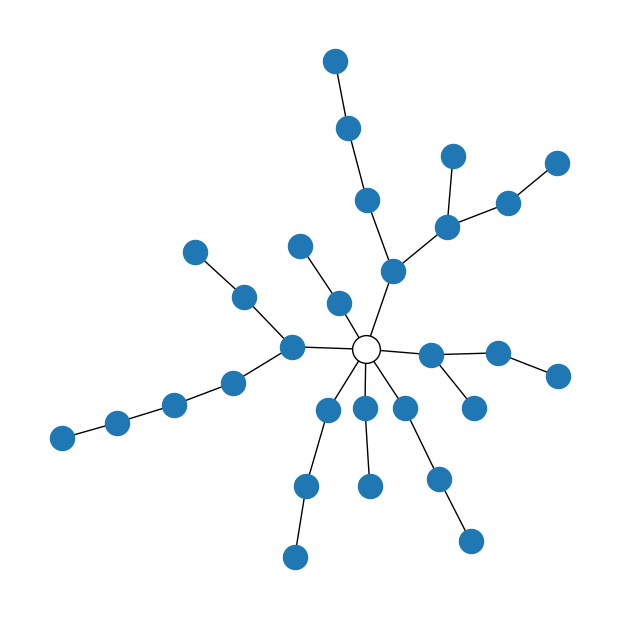

In [27]:
plt.rcParams["figure.figsize"] = (6,6)
pos = nx.kamada_kawai_layout(sa_network)
nx.draw(sa_network, pos=pos)
nx.draw_networkx_nodes(sa_network, pos=pos, nodelist = [-1], node_color = 'white', node_size = 400, edgecolors='black')
plt.show()

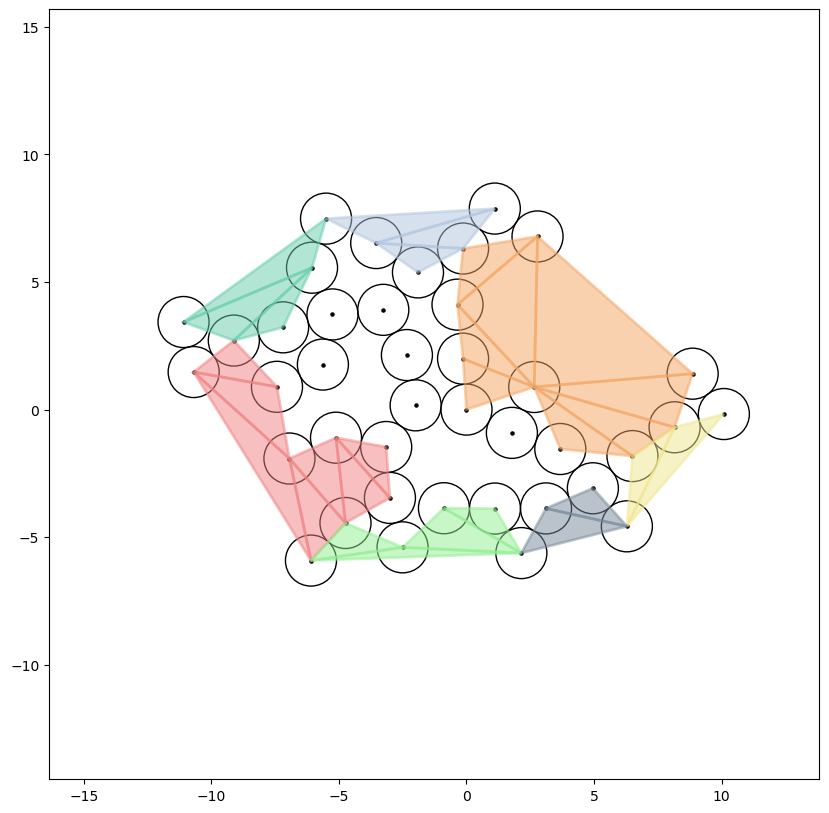

In [31]:
colors = ['lightcoral', 'sandybrown', 'khaki', 'lightgreen', 'mediumaquamarine', 'lightslategrey',
         'lightsteelblue', 'thistle']

plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_atoms):
    ax.add_patch(plt.Circle(coordinates[ii,:], radius= 1.0, color='k', fill=False))

plt.scatter(coordinates[:,0], coordinates[:,1], s=5, c='k')

for ii in range(len(sa_networks)):
    for asphere_index in sa_networks[ii]:
        aux = atoms_of_alphasphere[asphere_index]
        plt.fill(coordinates[aux,0], coordinates[aux,1], facecolor=colors[ii], alpha=0.5, edgecolor=colors[ii], linewidth=2)



l_box = np.abs(coordinates).max() + 4.0
center = coordinates.mean(0)
plt.axis('scaled')
plt.xlim(-l_box+center[0],l_box+center[0])
plt.ylim(-l_box+center[1],l_box+center[1])
plt.show()